# Reinforcement Learning

Name: Amirreza Velae

Student ID: 400102222

In this notebook we learn how to use PyTorch to train a Deep Q-Learning (DQN) agent on the [LunarLander-v2](https://gymnasium.farama.org/environments/box2d/lunar_lander/) task from [Gymnasium](https://gymnasium.farama.org/).

# Setup

We must first install the required packages.

In [4]:
!sudo apt-get update --quiet
!pip install imageio --quiet
!pip install imageio-ffmpeg
!sudo apt-get install -y xvfb ffmpeg --quiet
!pip install swig --quiet
!pip install gymnasium[box2d] --quiet

Hit:1 https://packages.cloud.google.com/apt gcsfuse-focal InRelease
Hit:2 https://packages.cloud.google.com/apt cloud-sdk InRelease
Hit:3 https://packages.cloud.google.com/apt google-fast-socket InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:8 http://security.ubuntu.com/ubuntu focal-security InRelease
Reading package lists...
Reading package lists...
Building dependency tree...
Reading state information...
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
xvfb is already the newest version (2:1.20.13-1ubuntu1~20.04.17).
0 upgraded, 0 newly installed, 0 to remove and 69 not upgraded.


Next we must import the following libraries.

In [5]:
import gymnasium as gym
import random
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from collections import namedtuple, deque

import base64
import json
import imageio
import IPython

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Here are some helper functions which will allow you to plot the training process and see the results by visualizing the gym environment.

In [6]:
# @title helper functions

# disable warnings
import logging
logging.getLogger().setLevel(logging.ERROR)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()
plt.xkcd(scale=1, length=100, randomness=2)
matplotlib.rcParams['figure.figsize'] = (12, 6)


def plot_rewards(sum_of_rewards, show_result=False):
    plt.figure(1)
    rewards = torch.tensor(sum_of_rewards, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(rewards.numpy())
    # Take 50 episode averages and plot them too
    length = len(rewards)
    init_len = min(49, length)
    init_means = np.cumsum(rewards[:init_len]) / (1 + np.arange(init_len))
    if length > 50:
        means = rewards.unfold(0, 50, 1).mean(1).view(-1)
        means = torch.cat((init_means, means))
    else:
        means = init_means
    plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


def embed_mp4(filename):
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    return IPython.display.HTML(tag)


def create_policy_eval_video(env, agent, filename, num_episodes=1, fps=30):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            state, info = env.reset()
            video.append_data(env.render())
            while True:
                state = torch.from_numpy(state).unsqueeze(0).to(device)
                action = agent.act(state, greedy=True)
                state, reward, terminated, truncated, info = env.step(action)
                video.append_data(env.render())
                if terminated or truncated:
                    break
    return embed_mp4(filename)


def save_progress(sum_of_rewards, PATH):
    # Convert the list to a JSON string
    json_data = json.dumps(sum_of_rewards)
    # Write the JSON data to a file
    with open(PATH + str('.json'), "w") as file:
        file.write(json_data)


def load_progress(PATH):
    with open(PATH + str('.json'), "r") as file:
        json_data = file.read()
    # Load the JSON data back into a Python list
    return json.loads(json_data)

# Explore the Environment (10 points)

First we must create the environment. In order to be able to render the environment we must use `rgb_array` as the render mode.

In [7]:
env = gym.make("LunarLander-v2", render_mode='rgb_array')

# TODO: Print the observation space and action space
observation = env.observation_space
actions = env.action_space

print('Observations:', observation)
print('Actions:', env.action_space)

Observations: Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
Actions: Discrete(4)


Complete the following class to have an agen which acts according to a random policy (randomly selects actions from the action space).

In [8]:
class RandomAgent(object):

    def __init__(self):
        self.env = gym.make("LunarLander-v2", render_mode='rgb_array')
        # self.env = env

    def act(self, state, greedy=None):
        # TODO: Select and return a random action
        action =  self.env.action_space.sample()
        return action

Visualize the random policy.

In [9]:
random_agent = RandomAgent()

create_policy_eval_video(env, random_agent, 'random_policy', num_episodes=5)

[swscaler @ 0x681b980] Warning: data is not aligned! This can lead to a speed loss


To learn more about this environment you can visit [here](https://gymnasium.farama.org/environments/box2d/lunar_lander/). Learning more about the environment is strongly recommended as it allows you to better understand the performance of your model.

# Replay Memory (15 points)

We'll be using experience replay memory for training our DQN. It stores the experiences that the agent observes, allowing us to reuse this data later. By sampling from it randomly, the experiences that build up a batch are decorrelated. It has been shown that this greatly stabilizes and improves the DQN training procedure.

For this, we're going to need a `ReplayMemory`: a cyclic buffer of bounded size that holds the experiences observed recently.

In order to implement the `ReplayMemory` we use the [deque](https://docs.python.org/3/library/collections.html#deque-objects) data structure to store the experiences.
We store each experience as a [namedtuple](https://docs.python.org/3/library/collections.html#collections.namedtuple) which will consist of state, action, next_state, reward, and done status of previous transitions.

Using the `.push` method we add new experiences to the memory. If the number of experiences exceed the maximum length of the memory (a.k.a. the capacity), the first experiences added to the memory will be removed to make space for the new experiences.

We also need to implement a `.sample` method for selecting a random batch of experiences for training. In this method we first sample a batch from the memory. Next we concatenate states, actions, reward, next_state, and done batches and then we return them.

In [61]:
class ReplayMemory(object):

    def __init__(self, capacity, batch_size):
        self.memory = deque([], maxlen=capacity)
        self.batch_size = batch_size
        transition_tuple = ('state', 'action', 'reward', 'next_state', 'done')
        self.experience = namedtuple('Experience', field_names=transition_tuple)

    def push(self, state, action, next_state, reward, done):
        # TODO: Save an experience
        self.memory.append(*zip(*self.experience(state, action, reward, next_state, done)))

    def sample(self):
        # TODO: Sample a batch from memory
        batch = random.sample(self.memory, self.batch_size)

        # TODO: Concatenate state, action, reward, next_state, and done batches
        states, actions, rewards, next_states, dones = zip(*batch)

        # TODO: Send tensors in states to cpu and concatenate them into a 2D tensor
        tensor_states = torch.zeros(len(states), len(states[0]))
        for i, state in enumerate(states):
            tensor_states[i] = state
        # TODO: Convert the batches to PyTorch tensors
        #states = torch.cat(states,1).to(device)

        tensor_next_states = torch.zeros(len(next_states), len(next_states[0]))
        for i, next_state in enumerate(next_states):
            tensor_next_states[i] = next_state
        # TODO: Convert the batches to PyTorch tensors
        #states = torch.cat(states,1).to(device)
        tensor_states = tensor_states.clone().detach().to(device)
        tensor_next_states = tensor_next_states.clone().detach().to(device)
        actions = torch.tensor(actions).to(device)
        rewards = torch.tensor(rewards).to(device)
        dones = torch.tensor(dones).to(device)

        # Return the concatenated values
        return tensor_states, actions.unsqueeze(-1), rewards.unsqueeze(-1), tensor_next_states, dones.unsqueeze(-1)
        # PEDARAT RA UNSQUEEZE KARDAMMMMMMMMMMMMMM AGHAYE PAYTHON

    def __len__(self):
        # TODO: Return length of memory
        return len(self.memory)

# Deep Q-Network (10 points)

Here we define the architecture of our Q-Network. In short, the network will try to predict the expected return of taking each action given its input which is the current state.

In [62]:
class QNetwork(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(QNetwork, self).__init__()
        self.n_actions = n_actions
        self.n_observations = n_observations
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)


    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

# Agent (40 points)

In this part we must design our Agent class which is the must important part of the notebook. First let's take a look at its methods:


*   `__init__` : initializes the agent, by receiving it the q_network, replay memory, optimize, criterion, and a dictionary of paramters which hold the hyperparameters of the agent.
*   `step` : allows the agent to store an experience in its memory and if necessary, it initiates the learning process.
*   `act` : by receiving a state and boolean value for choosing a greedy action, if the boolean value is false, it selects an $\varepsilon$-greedy action by passing the state to the policy network of the agent, and select the action with the highest state-action value. The $\varepsilon$ value is calculated using the following formula: $$\varepsilon = \varepsilon_{end} + \left(\varepsilon_{start} - \varepsilon_{end}\right)\exp\left(-\frac{\text{steps done}}{\text{decay rate}}\right)$$
*   `learn` : first computes the predicted Q-values for the observed states and actions using the policy network. Then, it computes the expected Q-values for the next states by evaluating the target network, incorporating rewards and discount factors. After computing the loss between predicted and expected Q-values, the function optimizes the model parameters using gradient descent. Additionally, it calls the soft update function to gradually update the target network's parameters towards the policy network's parameters.
*   `soft_update` : The target network is updated at every step with a soft update controlled by the hyperparameter $\tau$, which was previously defined. The target is updated according to: $$\theta' \leftarrow \tau \theta + (1 - \tau) \theta'$$ where $\theta'$ are the parameters of the target network and $\theta$ are the parameters of the policy network.
*   `save` and `load` : are used for saving and loading the policy and target networks of the agent.

In [67]:
import copy
class Agent(object):

    def __init__(self, q_network, memory, optimizer, criterion, params):
        # Create policy and target nets based on the q-net
        self.policy = q_network.to(device)
        self.target = copy.deepcopy(q_network).to(device)
        self.target.eval()

        # Setup the agent's memory
        self.memory = memory

        # Set other parameters
        self.batch_size = params['BATCH_SIZE']
        self.criterion = criterion
        self.optimizer = optimizer(self.policy.parameters(), lr=params['LR'], amsgrad=True)
        self.tau = params['TAU']
        self.gamma = params['GAMMA']
        self.update_rate = params['UPDATE_RATE']
        self.eps = {'START': params['EPS_START'], 'END': params['EPS_END'], 'DECAY': params['EPS_DECAY']}
        self.steps_done = 0

    def step(self, state, action, next_state, reward, done):
        # Save the experience in the memory of the agent
        self.memory.push(state, action, next_state, reward, done)
        # Increment the steps counter
        self.steps_done += 1
        if self.steps_done % self.update_rate == 0 and len(self.memory) > self.batch_size:
            # Sample a batch from memory and learn from it
            batch = self.memory.sample()

            # Learn from the batch
            self.learn(*batch)

    def act(self, state, my_eps=0, greedy=False):
        # This epsilon worked owfully, so I checked the rate and it became less than 0.01 +1e-5 after ~15 episodes,
        # so I changed the epsilon formula to be more efficient
        #eps_threshold = self.eps['END'] + (self.eps['START'] - self.eps['END']) * np.exp(- self.steps_done / self.eps['DECAY'])
        #eps_threshold = max(self.eps['END'], self.eps['START'] - self.steps_done * 1e-5)
        #eps_threshold = self.eps['END'] + (self.eps['START'] - self.eps['END']) * (1 - self.eps['DECAY']) ** self.steps_done
        eps_threshold = my_eps
        self.policy.eval()
        if greedy or random.random() > eps_threshold:
            with torch.no_grad():
                # Select greedy action
                state = state.clone().detach().unsqueeze(0).to(device)
                q_values = self.policy(state)
                action = q_values.argmax().item()
        else:
            # Select random action
            action = random.randrange(self.policy.n_actions)
        
        self.policy.train()
        return action

    def learn(self, states, actions, rewards, next_states, dones):
        # Compute the predicted Q-values using the policy network
        q_values = self.policy(states).gather(1, actions)

        # Compute expected Q-values using the target network
        with torch.no_grad():
            next_q_values = self.target(next_states).max(1)[0].detach().unsqueeze(1)
            expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        # Compute the loss
        loss = self.criterion(q_values, expected_q_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Run soft update
        self.soft_update()

    def soft_update(self):
        for target_param, policy_param in zip(self.target.parameters(), self.policy.parameters()):
            target_param.data.copy_(self.tau * policy_param.data + (1 - self.tau) * target_param.data)

    def save(self, PATH):
        torch.save(self.policy.state_dict(), PATH + '_policy.pt')
        torch.save(self.target.state_dict(), PATH + '_target.pt')

    def load(self, PATH):
        self.policy.load_state_dict(torch.load(PATH + '_policy.pt'))
        self.target.load_state_dict(torch.load(PATH + '_target.pt'))
        self.target_net = torch.load(PATH + '_target.pt')

# Training (15 points)

In order to train the ageant, you must first define the hyperparameters of the agent.

In [22]:
params = {
    'UPDATE_RATE':  4,        # how often to update the network
    'BUFFER_SIZE':int(1e5) ,  # replay buffer size
    'BATCH_SIZE': 64 ,        # number of experiences sampled from memory
    'GAMMA': 0.995,            # discount factor
    'EPS_START': 1.0 ,        # starting value of epsilon
    'EPS_END': 0.001 ,        # final value of epsilon
    'EPS_DECAY': 0.001 ,        # rate of exponential decay of epsilon
    'TAU': 0.001 ,             # update rate of the target network
    'LR': 0.0001              # learning rate of the optimizer
}

# Set the environment
env = gym.make("LunarLander-v2")
# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)
print(n_actions)
print(n_observations)
sum_of_rewards = list()

# TODO: Choose optimizer and loss function
optimizer = optim.Adam
criterion = nn.MSELoss()

# TODO: Get an instance of the agent class
agent = Agent(QNetwork(n_observations, n_actions), ReplayMemory(params['BUFFER_SIZE'], params['BATCH_SIZE']), optimizer, criterion, params)

4

8


Now that we have set the hyperparameters, we can proceed to train the agent. For your convenience, the following code segment has been written in a way which allows you to train your model for more episodes with a simple re-run. If you feel the agent hasn't yet achieved good results, you can simply run the following segment again to train it for more episodes.

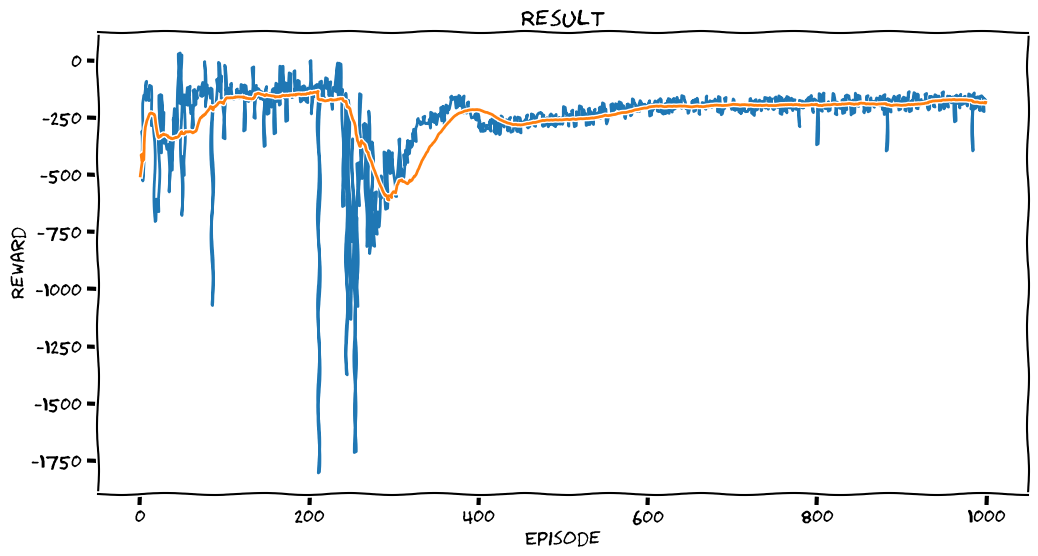

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [ ]:
num_episodes = 1000

for i_episode in range(1, num_episodes + 1):
    # TODO: Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    episode_reward, done = 0, False
    while not done:
        # TODO: Take an Ɛ-greedy action
        action = agent.act(state)

        # TODO: Take a step in the environment
        next_state, reward, terminated, truncated, info = env.step(action)

        # TODO: Update sum of rewards for current episode
        episode_reward += reward


        # TODO: Convert reward to tensor
        reward = torch.tensor(reward, dtype=torch.float32, device=device).unsqueeze(0)

        # TODO: Convert the next state into tensor
        next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)


        # TODO: Store the termination status into a tensor
        done = torch.tensor(done, dtype=torch.float32, device=device).unsqueeze(0)

        # TODO: Store the experience in memory
        agent.step(state, torch.tensor(action, dtype=torch.long, device=device).unsqueeze(0), next_state, reward, done)


        # TODO: Update done status
        done = truncated or terminated


        # TODO: Move to the next state
        state = next_state

    # Update and plot rewards
    sum_of_rewards.append(episode_reward)
    if i_episode % 20 == 0:
      plot_rewards(sum_of_rewards)
    # Save model every 100 episodes (change the rate if needed)
    if i_episode % 100 == 0:
        path = 'DQN_' + str(len(sum_of_rewards)).zfill(4)
        agent.save(path)
        save_progress(sum_of_rewards, path)

plot_rewards(sum_of_rewards, show_result=True)
plt.ioff()
plt.show()

In order to evaluate the model, we use the following function to measure the average reward and it's standard deviation.

# Evaluate the Model (10 points)

In [ ]:
def evaluate_policy(env, agent, num_episodes=10):
    # TODO: Initialize sum of rewards
    rewards = []

    agent.policy.eval()
    for episode in range(num_episodes):
      # TODO: Initialize environment
      state, info = env.reset()
      # state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
      episode_reward =0
      done = False
      print(np.expand_dims(state,0).shape)
      # TODO: Run policy
      while not done:
        if isinstance(state, tuple):
          state = state[0]
        # TODO: Take an greedy action
        action = agent.act(state,greedy=True)
        next_state, reward, done, truncated, info = env.step(action)
        episode_reward += reward

        agent.step(state, action, reward, next_state, done)

        state = next_state.unsqueeze(0)

      rewards.append(episode_reward)

    # TODO: Return mean and std of rewards
    mean_reward = np.mean(rewards)
    std_reward = np.std(rewards)
    return mean_reward, std_reward


In [ ]:
mean_reward, std_reward = evaluate_policy(env, agent)
print(f"mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}")

(1, 8)


KeyboardInterrupt: 

Show how the learned policy works.

In [ ]:
env = gym.make("LunarLander-v2", render_mode='rgb_array')
create_policy_eval_video(env, agent, 'greedy_policy', 3)

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

  self.pid = _posixsubprocess.fork_exec(

<ipython-input-28-2680e4bdcb0f>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

  state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


So my lunar lander actually does nothing :)

Also as I compared my rewards with the given rewards how should look like, I guees I'm not exploring enough.


# Training Part 2

In order to train the ageant, you must first define the hyperparameters of the agent.

In [69]:
params = {
    'UPDATE_RATE':  4,        # how often to update the network
    'BUFFER_SIZE':int(1e5) ,  # replay buffer size
    'BATCH_SIZE': 128 ,        # number of experiences sampled from memory
    'GAMMA': 0.99,            # discount factor
    'EPS_START': 1.0 ,        # starting value of epsilon
    'EPS_END': 0.01 ,        # final value of epsilon
    'EPS_DECAY': 2000 ,        # rate of exponential decay of epsilon
    'TAU': 0.001 ,             # update rate of the target network
    'LR': 0.0005              # learning rate of the optimizer
}

# Set the environment
env = gym.make("LunarLander-v2")
# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)
print(n_actions)
print(n_observations)
sum_of_rewards = list()

# TODO: Choose optimizer and loss function
optimizer = optim.Adam
criterion = nn.MSELoss()

# TODO: Get an instance of the agent class
agent = Agent(QNetwork(n_observations, n_actions), ReplayMemory(params['BUFFER_SIZE'], params['BATCH_SIZE']), optimizer, criterion, params)

4
8


Now that we have set the hyperparameters, we can proceed to train the agent. For your convenience, the following code segment has been written in a way which allows you to train your model for more episodes with a simple re-run. If you feel the agent hasn't yet achieved good results, you can simply run the following segment again to train it for more episodes.

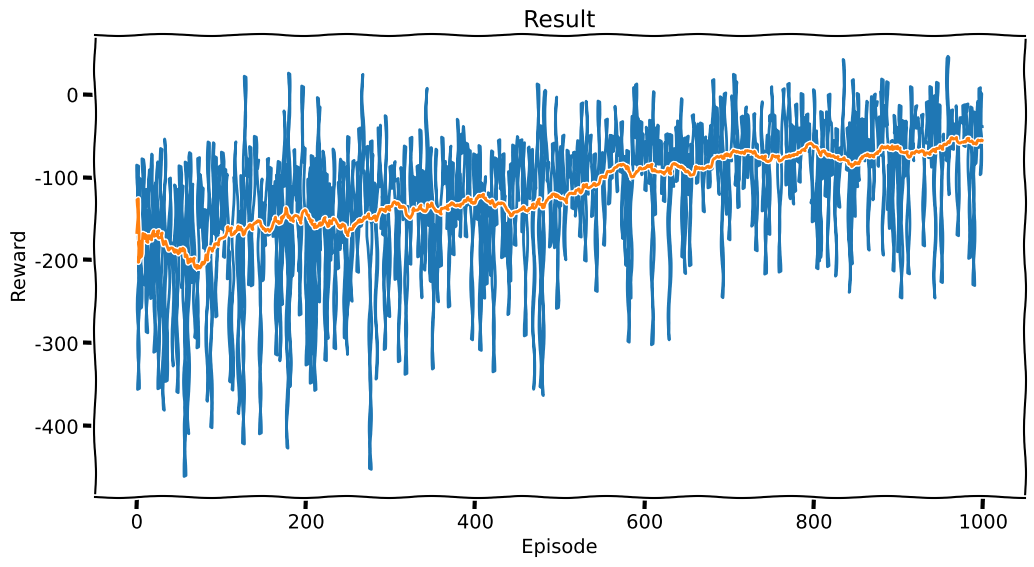

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [70]:
num_episodes = 1000

for i_episode in range(1, num_episodes + 1):
    # TODO: Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    episode_reward, done = 0, False
    while not done:
        # TODO: Take an Ɛ-greedy action
        eps = params['EPS_END'] + (params['EPS_START'] - params['EPS_END']) * np.exp(- i_episode / params['EPS_DECAY'])
        action = agent.act(state,eps)

        # TODO: Take a step in the environment
        next_state, reward, terminated, truncated, info = env.step(action)

        # TODO: Update sum of rewards for current episode
        episode_reward += reward


        # TODO: Convert reward to tensor
        reward = torch.tensor(reward, dtype=torch.float32, device=device).unsqueeze(0)

        # TODO: Convert the next state into tensor
        next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)


        # TODO: Store the termination status into a tensor
        done = torch.tensor(done, dtype=torch.float32, device=device).unsqueeze(0)

        # TODO: Store the experience in memory
        agent.step(state, torch.tensor(action, dtype=torch.long, device=device).unsqueeze(0), next_state, reward, done)


        # TODO: Update done status
        done = truncated or terminated


        # TODO: Move to the next state
        state = next_state

    # Update and plot rewards
    sum_of_rewards.append(episode_reward)
    if i_episode % 20 == 0:
        # For sake of my RAM!
        plot_rewards(sum_of_rewards)
    # Save model every 100 episodes (change the rate if needed)
    if i_episode % 100 == 0:
        path = 'DQN_' + str(len(sum_of_rewards)).zfill(4)
        agent.save(path)
        save_progress(sum_of_rewards, path)

plot_rewards(sum_of_rewards, show_result=True)
plt.ioff()
plt.show()

In [71]:
env = gym.make("LunarLander-v2", render_mode='rgb_array')
create_policy_eval_video(env, agent, 'greedy_policy', 3)

[swscaler @ 0x6670980] Warning: data is not aligned! This can lead to a speed loss


Didn't work (I almost ran it 60 times)

In [78]:
params = {
    'UPDATE_RATE':  4,        # how often to update the network
    'BUFFER_SIZE':int(1e6) ,  # replay buffer size
    'BATCH_SIZE': 128 ,        # number of experiences sampled from memory
    'GAMMA': 0.99,            # discount factor
    'EPS_START': 1.0 ,        # starting value of epsilon
    'EPS_END': 0.01 ,         # final value of epsilon
    'EPS_DECAY': 0.995 ,       # rate of exponential decay of epsilon
    'TAU': 0.001 ,            # update rate of the target network
    'LR': 0.0005              # learning rate of the optimizer
}

# Set the environment
env = gym.make("LunarLander-v2")
# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)
print(n_actions)
print(n_observations)
sum_of_rewards = list()

# TODO: Choose optimizer and loss function
optimizer = optim.Adam
criterion = nn.L1Loss()

# TODO: Get an instance of the agent class
agent = Agent(QNetwork(n_observations, n_actions), ReplayMemory(params['BUFFER_SIZE'], params['BATCH_SIZE']), optimizer, criterion, params)

4
8


0.01


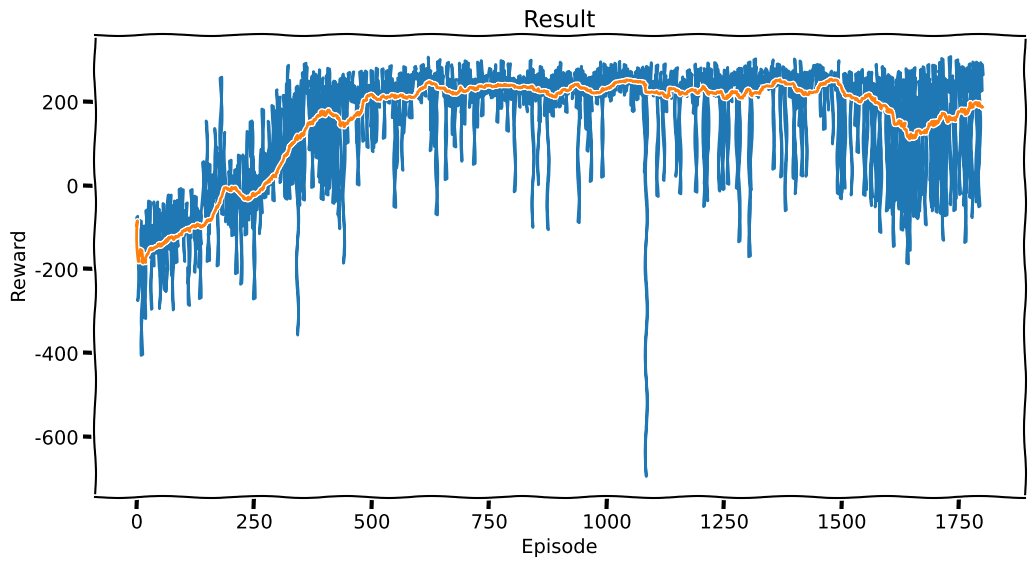

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [79]:
num_episodes = 1800
eps = params['EPS_START']
for i_episode in range(1, num_episodes + 1):
    # TODO: Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    episode_reward, done = 0, False
    eps = max(params['EPS_END'],params['EPS_DECAY']*eps)
    while not done:
        # TODO: Take an Ɛ-greedy action
        action = agent.act(state,eps)

        # TODO: Take a step in the environment
        next_state, reward, terminated, truncated, info = env.step(action)

        # TODO: Update sum of rewards for current episode
        episode_reward += reward


        # TODO: Convert reward to tensor
        reward = torch.tensor(reward, dtype=torch.float32, device=device).unsqueeze(0)

        # TODO: Convert the next state into tensor
        next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)


        # TODO: Store the termination status into a tensor
        done = torch.tensor(done, dtype=torch.float32, device=device).unsqueeze(0)

        # TODO: Store the experience in memory
        if i_episode<300 or reward >0 or reward < -100:
            agent.step(state, torch.tensor(action, dtype=torch.long, device=device).unsqueeze(0), next_state, reward, done)
        else:
            # I guess this will stop my stupid idiot lunar lander to do nothing
            # I'm telling him that if you are doing nothing, I'll punish you 5 times more than you deserve
            reward * 5
            agent.step(state, torch.tensor(action, dtype=torch.long, device=device).unsqueeze(0), next_state, reward, done)


        # TODO: Update done status
        done = truncated or terminated


        # TODO: Move to the next state
        state = next_state

    # Update and plot rewards
    sum_of_rewards.append(episode_reward)
    if i_episode % 20 == 0:
        # For sake of my RAM!
        plot_rewards(sum_of_rewards)
    # Save model every 100 episodes (change the rate if needed)
    if i_episode % 300 == 0:
        print(eps)
        path = 'DQN_' + str(len(sum_of_rewards)).zfill(4)
        agent.save(path)
        save_progress(sum_of_rewards, path)

plot_rewards(sum_of_rewards, show_result=True)
plt.ioff()
plt.show()

# BE EMAM ZAMAN KE MAN KHODE <font color = red> KHODAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAM</font>

In [80]:
env = gym.make("LunarLander-v2", render_mode='rgb_array')
create_policy_eval_video(env, agent, 'greedy_policy', 3)

[swscaler @ 0x6361980] Warning: data is not aligned! This can lead to a speed loss


In [101]:
def evaluate_policy(env, agent, num_episodes=10):
    # TODO: Initialize sum of rewards
    rewards = []

    agent.policy.eval()
    for episode in range(num_episodes):
      # TODO: Initialize environment
      state, info = env.reset()
      state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
      # state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
      episode_reward =0
      done = False
      # TODO: Run policy
      while not done:
        action = agent.act(state,greedy=True)
        next_state, reward, terminated, truncated, info = env.step(action)
        episode_reward += reward
        reward = torch.tensor(reward, dtype=torch.float32, device=device).unsqueeze(0)
        next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
        done = torch.tensor(done, dtype=torch.float32, device=device).unsqueeze(0)
        
        reward = torch.tensor(reward, dtype=torch.float32, device=device).unsqueeze(0)
        next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
        done = torch.tensor(done, dtype=torch.float32, device=device).unsqueeze(0)
        
        # TODO: Update done status
        done = truncated or terminated

        state = next_state

      rewards.append(episode_reward)

    # TODO: Return mean and std of rewards
    mean_reward = np.mean(rewards)
    std_reward = np.std(rewards)
    return mean_reward, std_reward

In [102]:
mean_reward, std_reward = evaluate_policy(env, agent)
print(f"mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}")

/tmp/ipykernel_34/2644577713.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reward = torch.tensor(reward, dtype=torch.float32, device=device).unsqueeze(0)
/tmp/ipykernel_34/2644577713.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
/tmp/ipykernel_34/2644577713.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  done = torch.tensor(done, dtype=torch.float32, device=device).unsqueeze(0)


mean_reward = 97.06 +/- 133.9521
